## Grafové modely v strojovom učení, úloha APP2
### Vladimír Macko

Máme zašumené GPS súradnice človeka a chceme zistiť, kedy stál (prejvoval sa len šum), kedy kráčal a kedy šiel autom. Bohužial máme len neanotované dáta.

V tomto texte sa budeme odkazovať na rýchlosť v človeka v dátach. 
V dátach sa ale nachádzajú len polohy. 
Rýchlosť získame tak, že zistíme vydialenosť medzi dvomi po sebe idúcimi polohami v dátach a predelíme ich rozdielom časov, v ktorých boli namerané.
Pre jednoduchosť sme použili klasickú euklidovskú vzdialenosť, pričom vertikálna vzdialenosť (prevýšenie) bola zarátavná dvatsaťnásobne. 

Teraz sa pokúsime jednotlivé stavy nášho človeka popísať vlastnosťami z dát.
Ak človek išiel autom, jeho rýchlosť bola oveľa väčšia, ako keby išiel pešo. 
Toto vidíme aj v dátach, kde sa nachádzajú dlhé úseky z rýchlosťou pohybu okolo 31 metrov za sekundu, čo je približne 70 míľ za hodinu, čo je rýchlostný limit v Pensilvánií. 
Podobne sa v dátach nachádzajú úseky s rýchlosťou okolo 15 metrov za sekundu, čo predpokladám že je dedina, respektíve obec.

Keď človek stojí, prejavuje sa len šum GPS. Budeme predpokladať, že vplyvom šumu môže byť naša pozícia podľa GPS posunutá oproti reálnej poziícií, kokrétne GPS pozícia je naša reálna pozícia plus nejaký gausovský šum so strednou hodnotou 0 a nie príliš veľkou disperziou.

Vplyvom tohoto šumu sa potom bude zdať, že máme nenulovú rýchlosť, aj keď sa v skutočnosti nehýbeme. 
Tieto vektri rýchlostí môžu smerovať do náhodných smerov a mať náhodné veľkosti. 

Keď sa človek pohybuje, tak je situácia podobná, ako keď stojí. 
GPS poloha je jeho skutočná poloha plus nejaký šum.
Dvôležité ale je, že človek by mal mať nenulovú rýchlosť nie len vplyvom šumu, ale aj preto, že sa naozaj hýbe. 
Dvôležité je, že vektor rýchlosti je v tomto prípade dlší, ako keď sa človek nehýbe. Dokonca to platí aj keď je vplyv šumu porovnateľný s pohybom človeka

In [57]:
%matplotlib inline  
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
from bs4 import BeautifulSoup as bs
from geopy.distance import vincenty  # na robenie s polarnymi suradnicami
import glob

In [292]:
def read_time(x):
    return parser.parse(x).timestamp()

zero = (4.15228128e+01,  -7.72349707e+01)  # Zaciatok suradnicovj sustavy
data = []
names = []
original = []
for fname in sorted(glob.glob("gpsdata/*")):    
    f = open(fname)
    soup = bs(f.read(), "lxml")
    #for track in soup.select("trk"):  # zretazime vsetky trk elementy
    for track in [soup]:
        original.append([x.text for x in track.select("trkpt")])
        points = [[float(x['lat']), 
               float(x['lon']), 
               float(x.select('ele')[0].text), 
               read_time(x.select('time')[0].text)] for x in track.select("trkpt")]
        
        # urobime transformaciu z polarnych suradnic do pravouhleho. Mozno stratime nejaku presnost, 
        # ale pri datach z tak maleho rozmedzia nam to nevadi

        points = [[vincenty(zero, (x[0], zero[1])).meters,
                   vincenty(zero, (zero[0], x[1])).meters, x[2], x[3]]  for x in points]
        
        if len(points) > 100: #  zaujimaju nas len dlhe prechadzky
            points = np.array(points)
            points[:,:3] -= points[:,:3].mean(axis=0)   # znormalizujeme, aby sa to lepsie vykeslovalo do grafov
            points[:,3] -= points[:,3].min()
            data.append(points)
            #names.append(track.select("name")[0].text)
            names.append(fname)


Každý súbor obsahuje niekoľko elementov s menom trk. Každý súbor sme ale považovali za jednu cestu a jednoducho sme elementy trk zreťazili za seba. 
Pri prechode medzi jednotlivými elementami sa ale často objavovali veľké nespojitosti, ktoré nám kazili grafy. 

In [293]:
# zratame si rozdiely
differences = []
for i, d in enumerate(data):
    d = data[i]
    difs = d[1:] - d[:-1]
    
    if difs[:,3].min() < -0.0001:
        print("Time travel detected")
        print(i)
        print(names[i])
        print(difs[:,3].argmin())
    difs = np.concatenate((difs, d[:-1,3:]), axis=1)
    
    differences.append(difs)

Time travel detected
0
gpsdata/20081009.gpx
10


In [294]:
"Mame dokopy {0:d} vychadzok".format(len(data))

'Mame dokopy 12 vychadzok'

Casove medzery


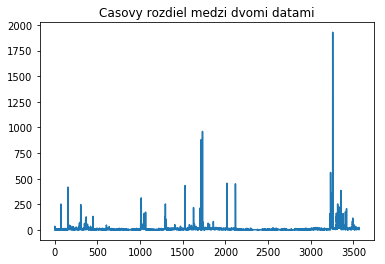

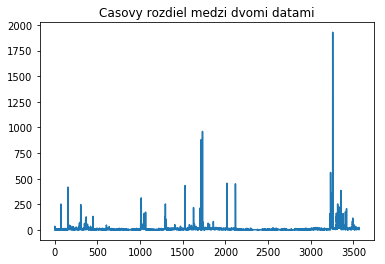

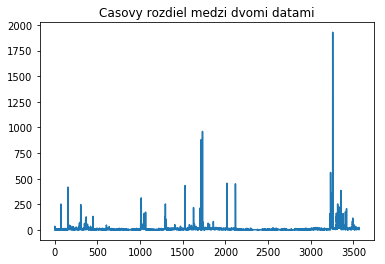

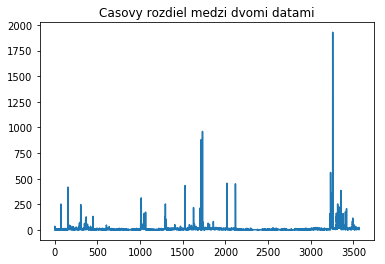

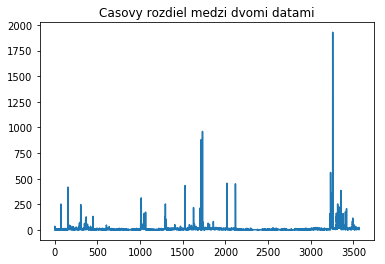

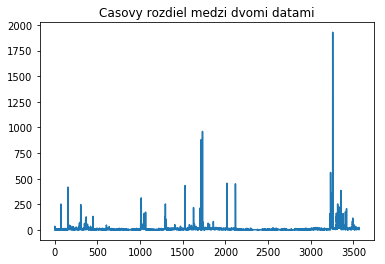

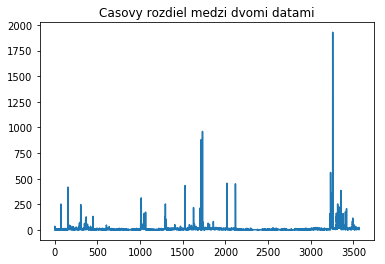

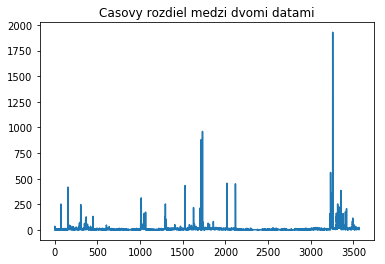

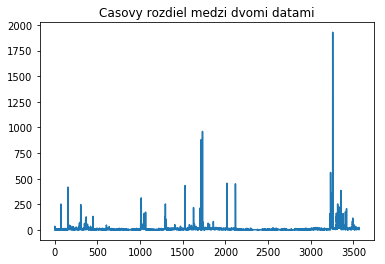

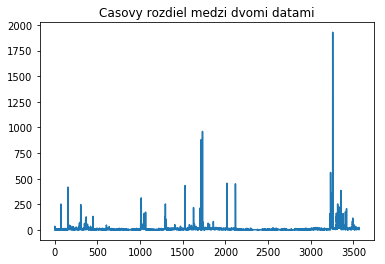

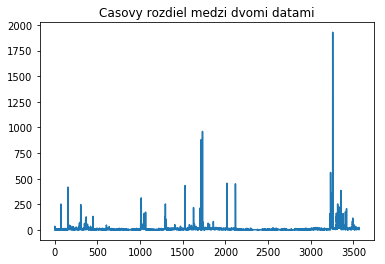

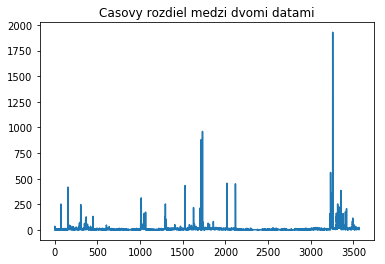

In [297]:
print("Casove medzery")
for diff in differences:
    plt.plot(difs[:,3])
    plt.title("Casovy rozdiel medzi dvomi datami")
    plt.show()

Subor gpsdata/20081009.gpx


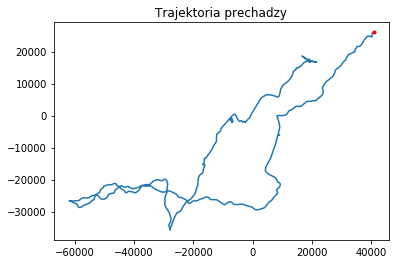

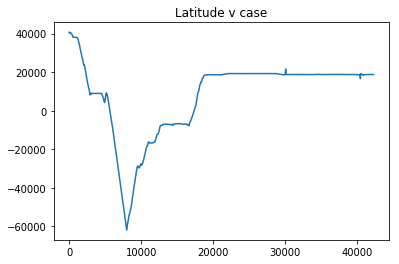

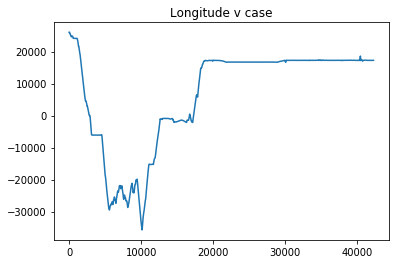

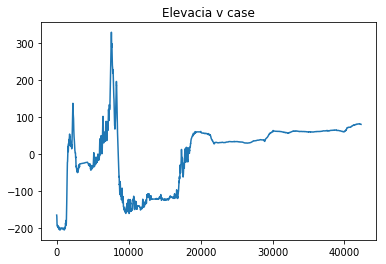

Subor gpsdata/20081010.gpx


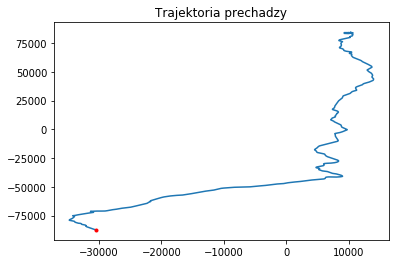

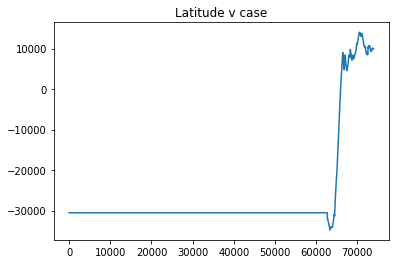

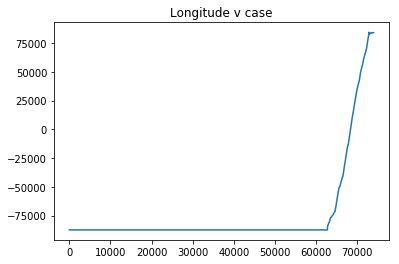

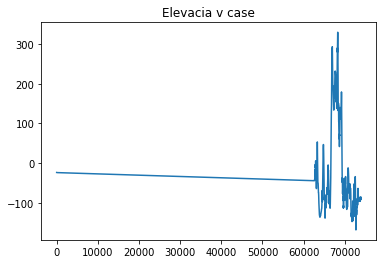

Subor gpsdata/20081011.gpx


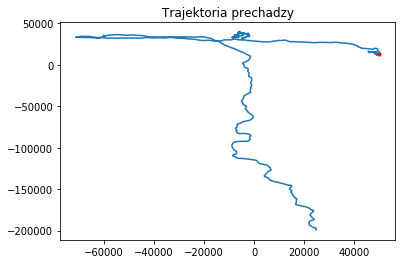

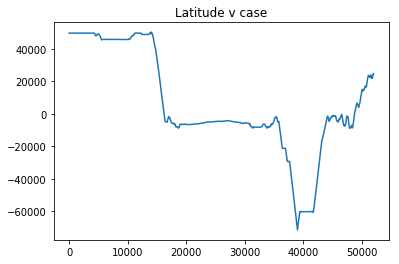

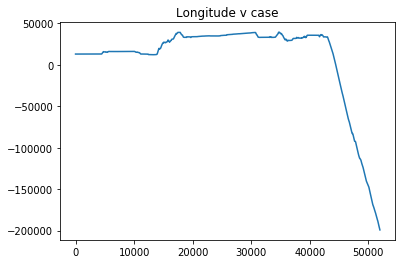

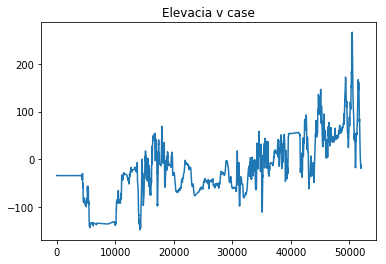

Subor gpsdata/20081012.gpx


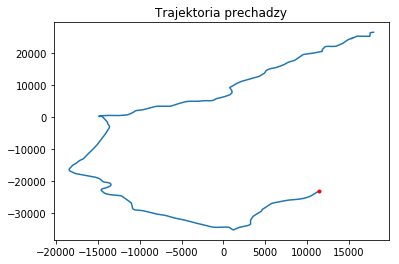

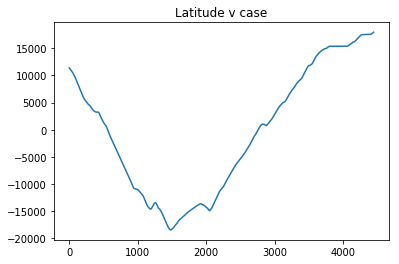

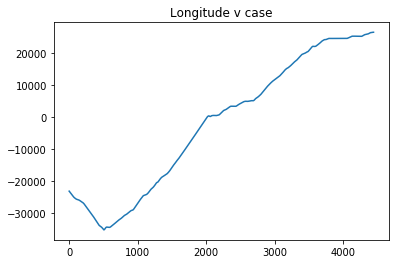

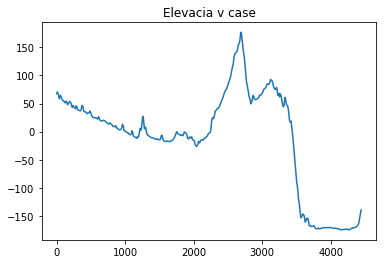

Subor gpsdata/20081017.gpx


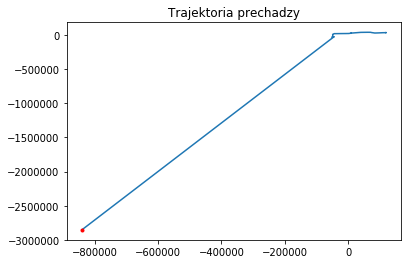

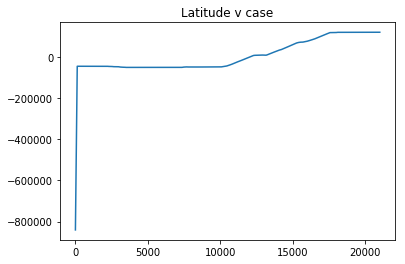

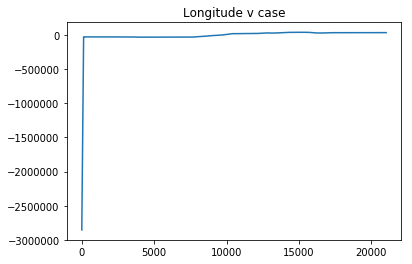

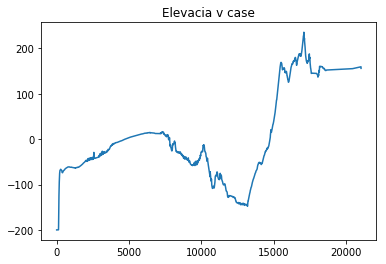

Subor gpsdata/20081018.gpx


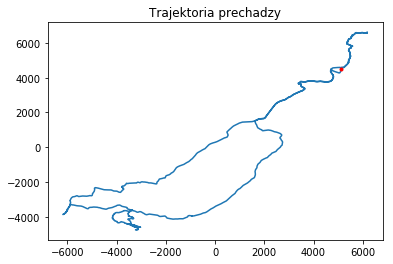

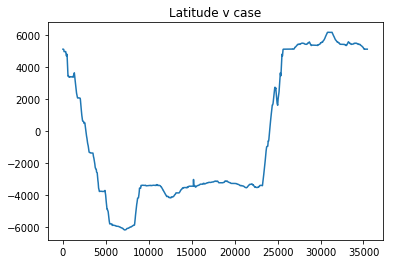

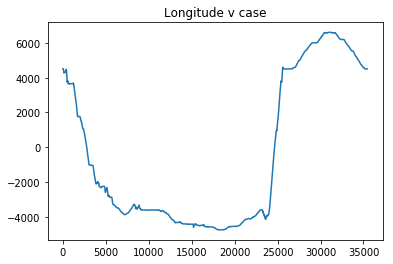

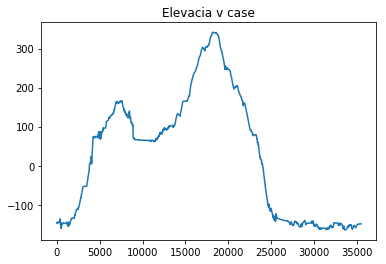

Subor gpsdata/20081019.gpx


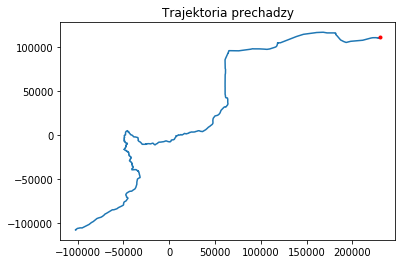

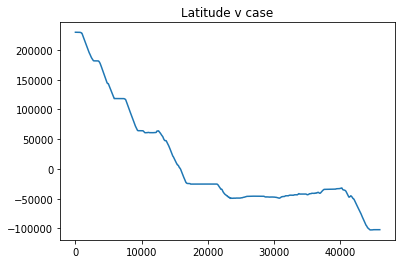

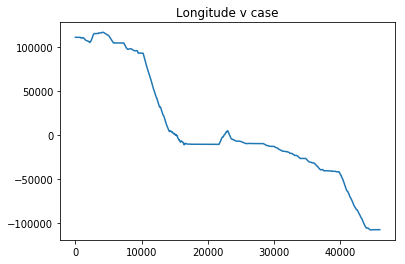

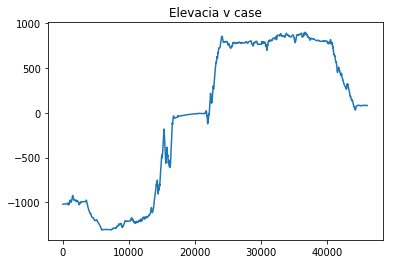

Subor gpsdata/20081020.gpx


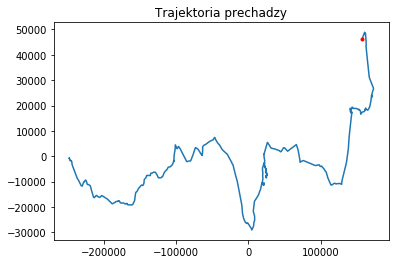

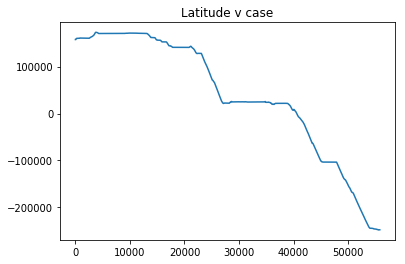

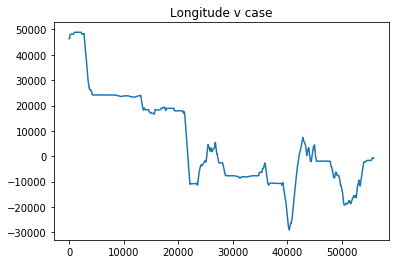

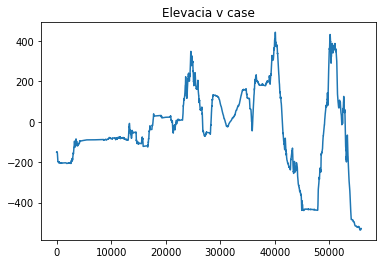

Subor gpsdata/20081021.gpx


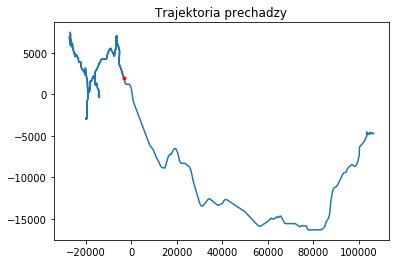

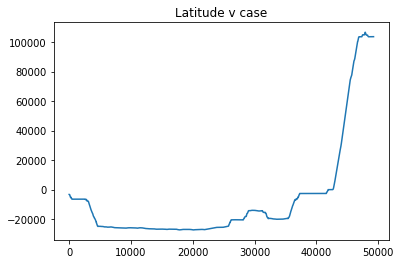

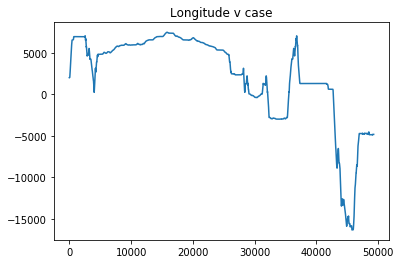

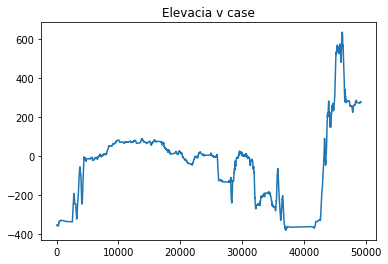

Subor gpsdata/20081022.gpx


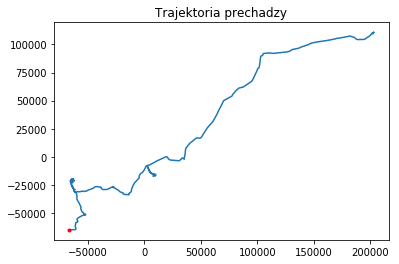

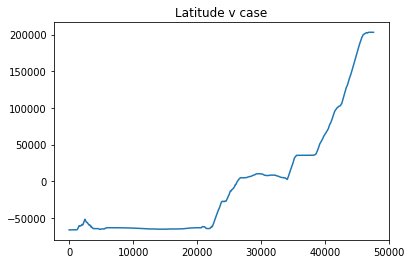

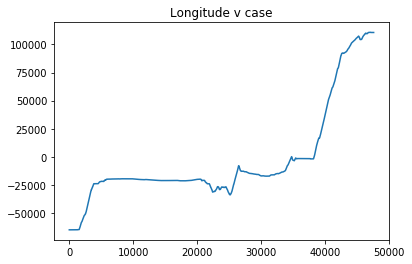

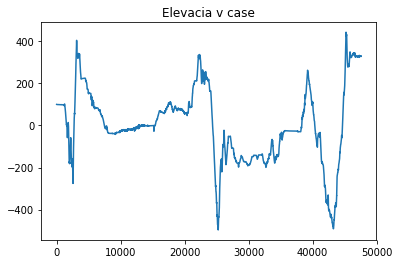

Subor gpsdata/20081023.gpx


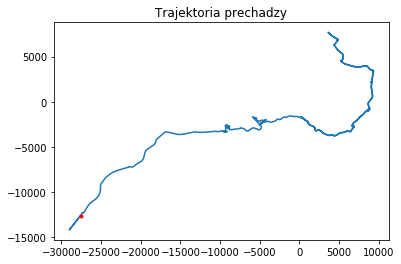

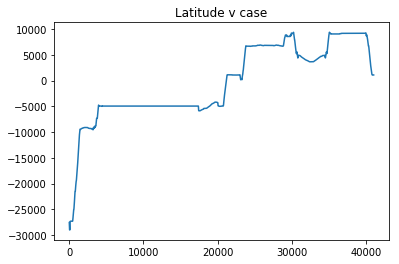

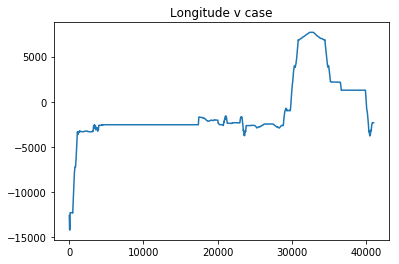

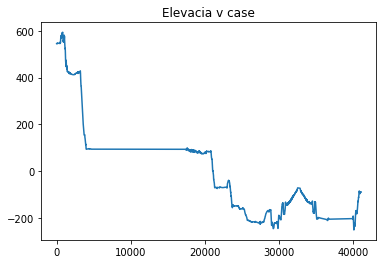

Subor gpsdata/20081024.gpx


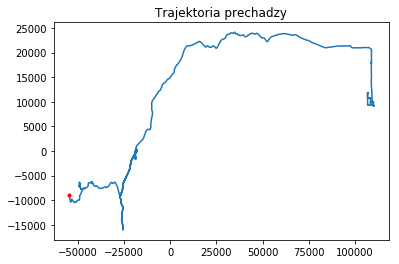

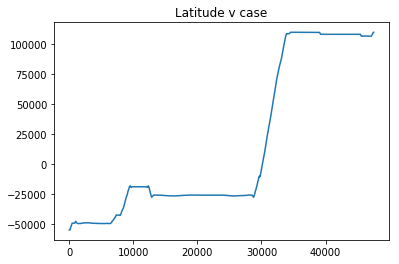

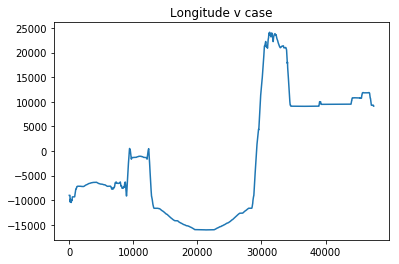

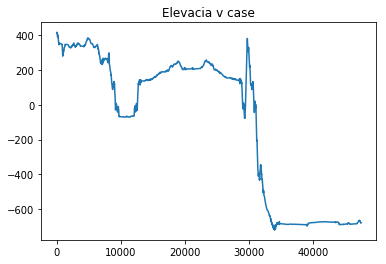

In [296]:
for i, points in enumerate(data):
    print("Subor {0:s}".format(names[i]))
    plt.plot(points[:,0], points[:,1])
    plt.plot(points[:1,0], points[:1,1], 'r.')  # cevena bodka na starte
    plt.title("Trajektoria prechadzy")
    plt.show()
    plt.plot(points[:,3], points[:,0])
    plt.title("Latitude v case")
    plt.show()
    plt.plot(points[:,3], points[:,1])
    plt.title("Longitude v case")
    plt.show()
    plt.plot(points[:,3], points[:,2])
    plt.title("Elevacia v case")
    plt.show()    

Časi v dátach sú nepravidelné, dokonca v súbore 20081009.gpx (track ACTIVE LOG121455) sa jeden záznam vráti v čase (približne dvanásty).
Všetky súradnice sú z jednej oblasti niekde v Pensilvánií v rozmedzí približne 100 km. 
Dáta sme si preto previedli z polárnej súradnicovej sústavy do normálnej, kde sme do istej miery zanedbali zakrivenie Zeme a ako počiatok súradnicovej sústavy sme zvolili latitude 41.522812 a longitude -77.234. 
To, že dáta sú z ameriky vysvetľuje, prečo sú často cesty až príliš rovné.

In [313]:
def to_velocities(data):
    norms = (data[:,:2]**2).sum(axis=1) + 20*(data[:,2]**2)  # zratame vzdialenost dvoch poloh
    norms = norms**0.5
    velocity = np.multiply(norms, 1./data[:,3])  # zratame rychlos

    velocity[velocity>30] = 30  # orezeme velke rychlosti
    velocity[velocity<0] = 0  # orezeme cestovatelov v case
    return velocity

In [323]:
def to_difference(data):
    return np.concatenate((data[1:,:4]-data[:-1,:4] , data[:-1,3:]), axis=1)

gpsdata/20081009.gpx


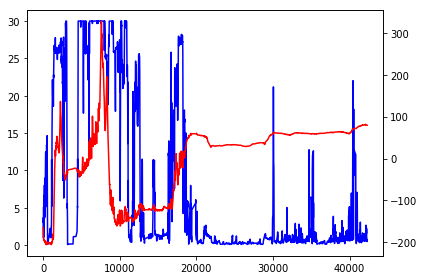

gpsdata/20081010.gpx


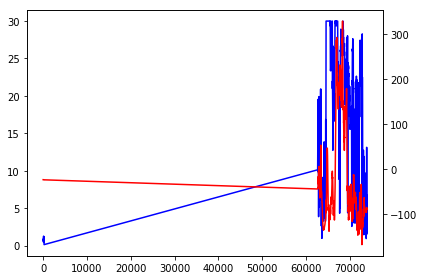

gpsdata/20081011.gpx


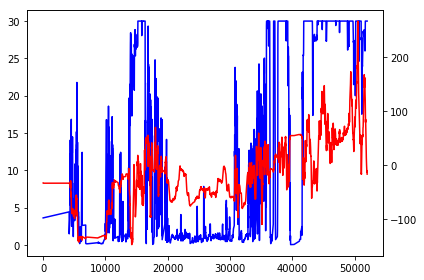

gpsdata/20081012.gpx


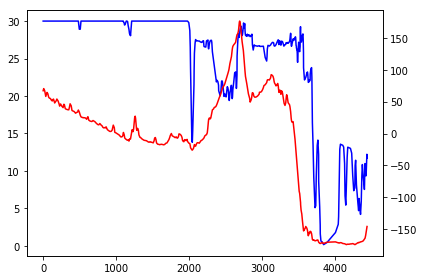

gpsdata/20081017.gpx


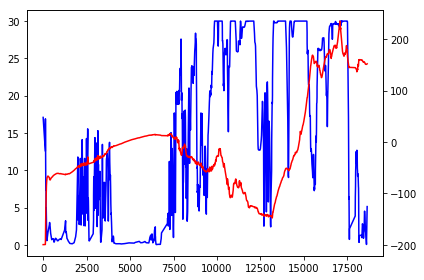

gpsdata/20081018.gpx


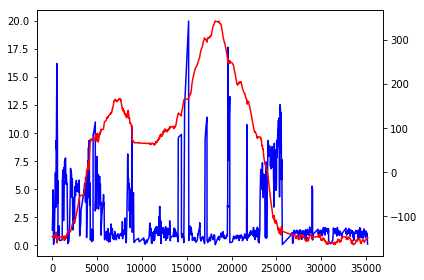

gpsdata/20081019.gpx


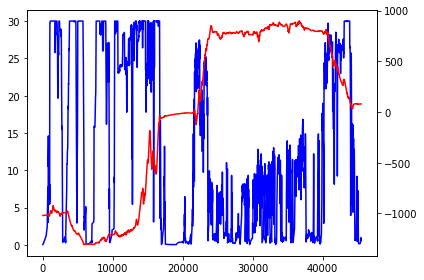

gpsdata/20081020.gpx


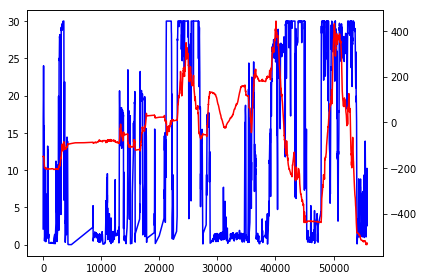

gpsdata/20081021.gpx


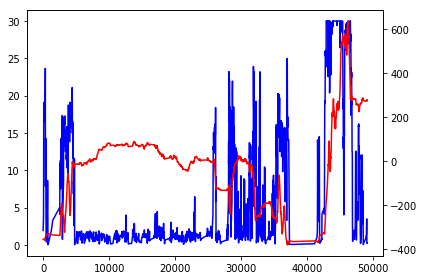

gpsdata/20081022.gpx


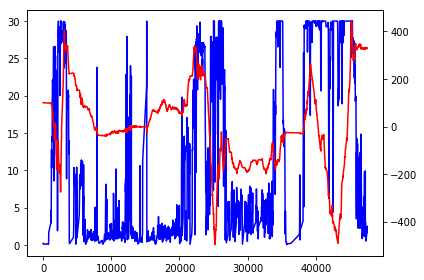

gpsdata/20081023.gpx


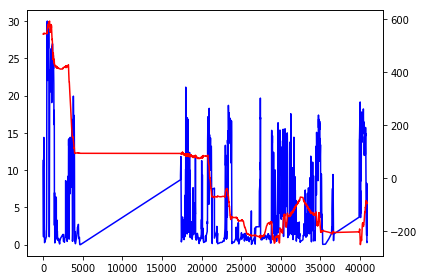

gpsdata/20081024.gpx


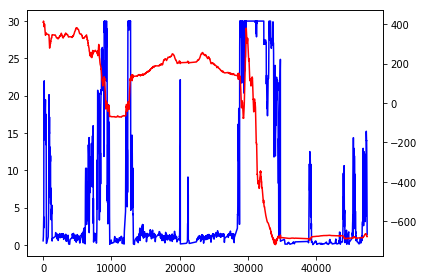

In [325]:
speeds = np.array([])
for i, points in enumerate(data):
    print(names[i])
    difs = to_difference(points)
    velocity = to_velocities(difs)
    
    speeds = np.concatenate((speeds, velocity))
    fig, ax1 = plt.subplots()
    ax1.plot(difs[:-2,4], (velocity[:-2]+velocity[1:-1]+velocity[2:])/3, 'b-')
    ax2 = ax1.twinx()
    ax2.plot(difs[:-2,4], points[:-3,2], 'r-')
    fig.tight_layout()
    plt.show()    

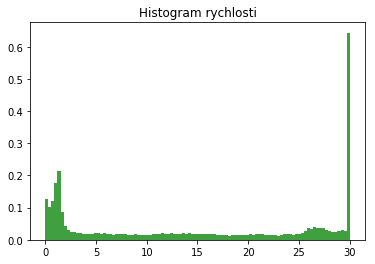

In [326]:
filtered = speeds
n, bins, patches = plt.hist(filtered, 100, normed=1, facecolor='green', alpha=0.75)
plt.title("Histogram rychlosti")

Vydíme, že histogram rýchlostí má štiry výrazné kopčeky. Budeme predpokladať, že prvý kopček je spôsobený stáním a druhý chvôdzov. Tretí a štvrtý sú spôsobené cestovaním autom. 

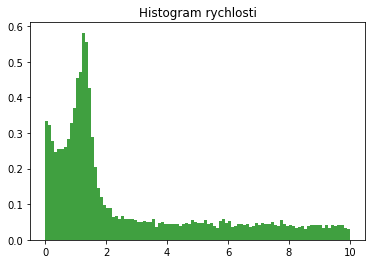

In [304]:
filtered = speeds[speeds<10]
n, bins, patches = plt.hist(filtered, 100, normed=1, facecolor='green', alpha=0.75)
plt.title("Histogram rychlosti")

Pre potreby vizualizácie odstránime hodnoty nad 10 avidíme výrazné prvé dva kopčeky.

Každopádne máme aspoň zčasti zvalidizovanú hypotézu, že rýchlosti pohybu sú rozdelené medzi niekoľkými stavmi. 

Môžme pristúpiť k voľbe modelu a k voľbe spôsobu trénovania. Vieme, že nás budú zaujímať len rýchlosti. 

Chcely by sme tri stavy, pričom jeden je státie, jeden je kráčanie a jeden je presun autom. 
Každý z týchto stavov má nejakú špecifickú rýchlosť a toleruje isté odchýlky. To znamená, že chceme použiť spojité HMM.

Podľa zadania by človek predpokladal, že nám stačí vynútiť veľmi špecifickú štruktúru prechodov. Najprv cesta autom, potom trochu státia, potom chodenie striedané so státím a potom znovu cesta autom. 
Z pohľadu na dáta to ale tak nevyzerá.

Turistika v amerike totiž (aspoň z mojej skúsenosti) pozostová z niekoľkých krátkych túr, medzi ktorými sa človek presúva autom. Okrem toho to vyzerá, že GPS bolo často zapnuté až po príchode na miesto, a vypnuté pred nasadnutím do auta. 

Modli by sme zobrať jednoduché hmm s tromi stavmi ktoré tvoria kompletný graf a nechať algortimus EM nech si poradí. Modli by sme ale dostať model, ktorý by vôbec nezodpovedal naším predstavám.

Vieme, že zmena stavov sa nedeje príliš často. Podobne máme istú informáciu o tom, ako by mali vyzerať emisie v jednotlivých stavoch. 
Nainicializujeme hmm podľa naši približných predstáv a následne ho len dotrénujeme pomocou štandardného EM algoritmu.
Použijeme už naimplementované knižnice.


In [309]:
from hmmlearn import hmm
np.random.seed(42)

Použijeme balíček hmmlrearn, ktrý bol kedisy súčasťou sklearnu. Nainicializujeme hmm na rozumné hodnoty a natrénujeme ho na našich dátach.

In [444]:
model = hmm.GaussianHMM(n_components=3, covariance_type="diag")
model.startprob_ = np.array([0.5, 0.5, 0.0])
model.transmat_ = np.array([[0.999, 0.001, 0.0],     # auto
                            [0.05, 0.9, 0.05],  # stoji
                            [0.0, 0.001, 0.999]])      # peso
model.means_ = np.array([[30], [0.1], [1.8]])
model.covars_ = [[[2]],[[2]],[[10]]]
model.n_features = 1

In [445]:
difs = to_difference(data[0])
vel = to_velocities(difs).reshape(-1,1)

In [446]:
all_velocities = [to_velocities(to_difference(x)).reshape(-1,1) for x in data]
train_data = np.concatenate(all_velocities)
lengths = [len(x) for x in all_velocities]

In [441]:
model.fit(train_data, lengths)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWar

gpsdata/20081009.gpx


/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3665 but corresponding boolean dimension is 3664


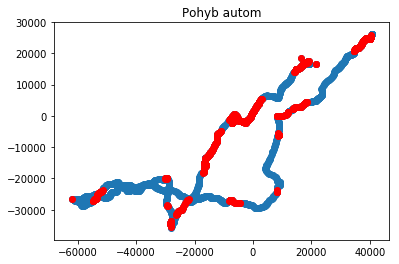

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3665 but corresponding boolean dimension is 3664


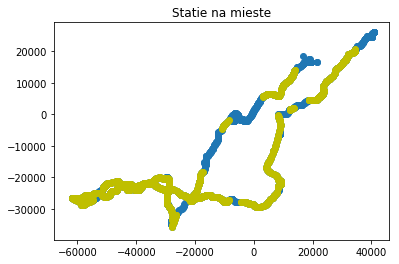

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3665 but corresponding boolean dimension is 3664


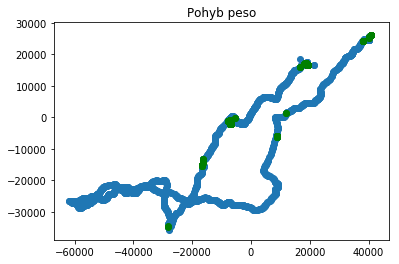

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1924 but corresponding boolean dimension is 1923


gpsdata/20081010.gpx


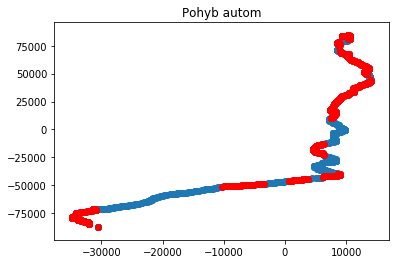

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1924 but corresponding boolean dimension is 1923


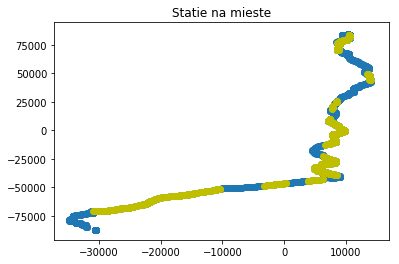

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1924 but corresponding boolean dimension is 1923


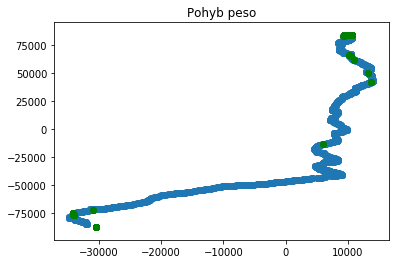

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4937 but corresponding boolean dimension is 4936


gpsdata/20081011.gpx


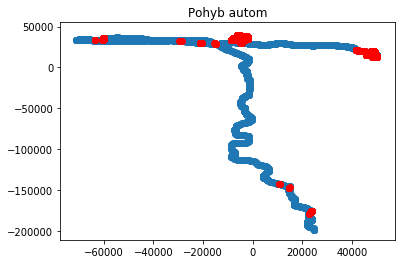

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4937 but corresponding boolean dimension is 4936


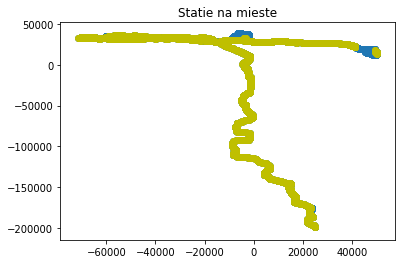

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4937 but corresponding boolean dimension is 4936


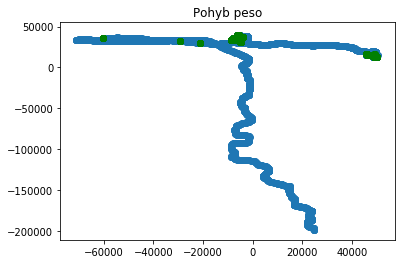

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 561 but corresponding boolean dimension is 560


gpsdata/20081012.gpx


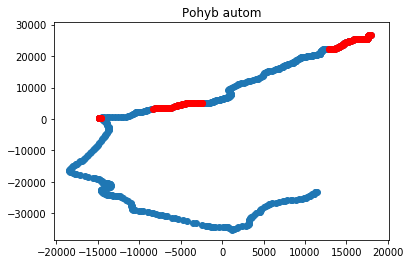

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 561 but corresponding boolean dimension is 560


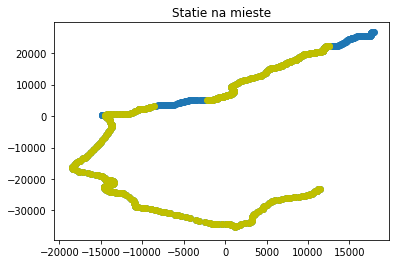

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 561 but corresponding boolean dimension is 560


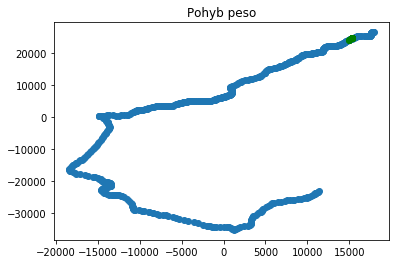

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1263 but corresponding boolean dimension is 1262


gpsdata/20081017.gpx


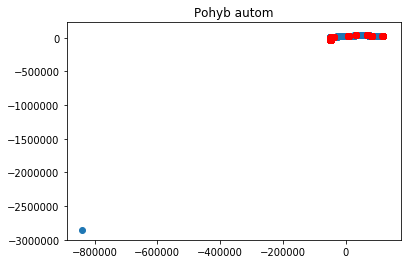

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1263 but corresponding boolean dimension is 1262


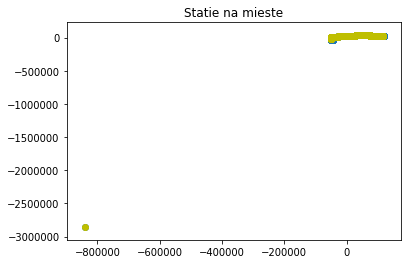

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1263 but corresponding boolean dimension is 1262


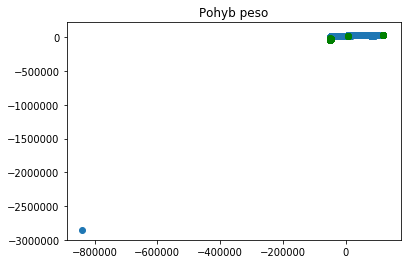

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2119 but corresponding boolean dimension is 2118


gpsdata/20081018.gpx


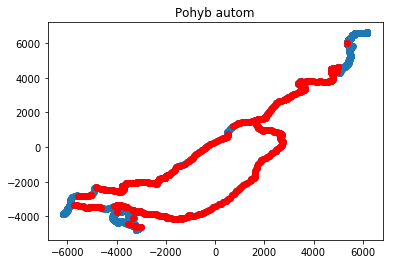

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2119 but corresponding boolean dimension is 2118


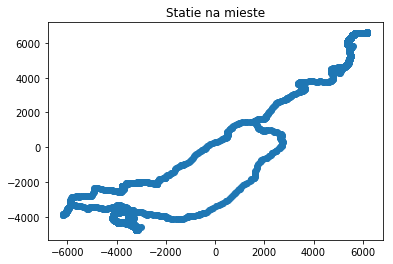

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2119 but corresponding boolean dimension is 2118


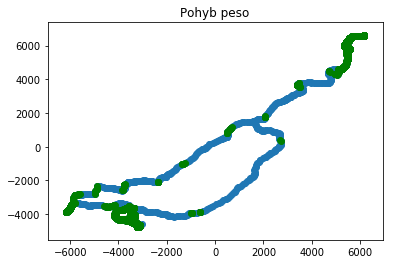

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4874 but corresponding boolean dimension is 4873


gpsdata/20081019.gpx


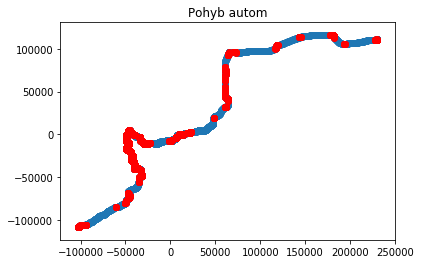

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4874 but corresponding boolean dimension is 4873


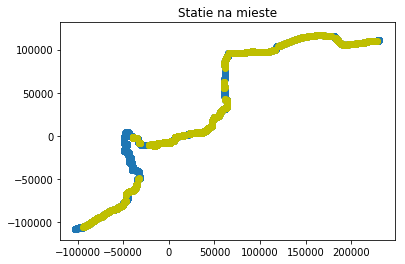

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4874 but corresponding boolean dimension is 4873


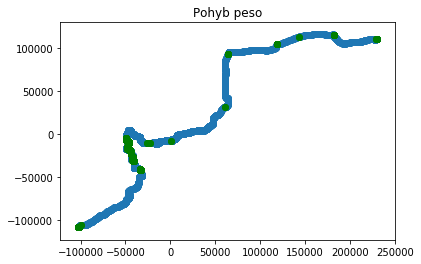

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


gpsdata/20081020.gpx


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5169 but corresponding boolean dimension is 5168


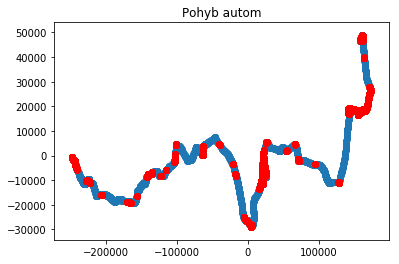

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5169 but corresponding boolean dimension is 5168


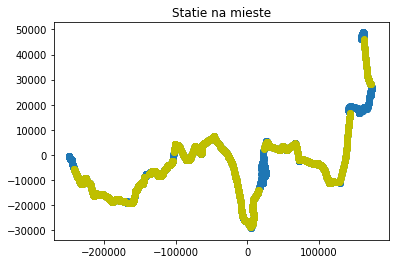

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5169 but corresponding boolean dimension is 5168


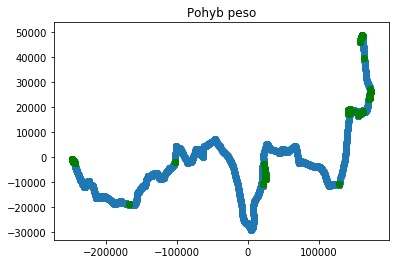

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4435 but corresponding boolean dimension is 4434


gpsdata/20081021.gpx


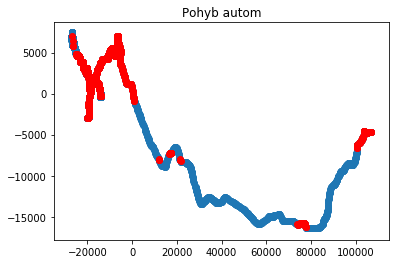

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4435 but corresponding boolean dimension is 4434


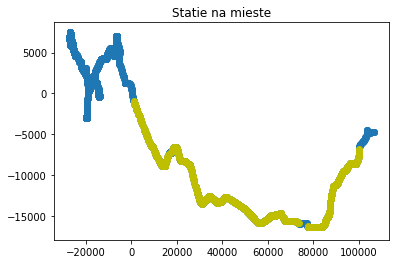

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4435 but corresponding boolean dimension is 4434


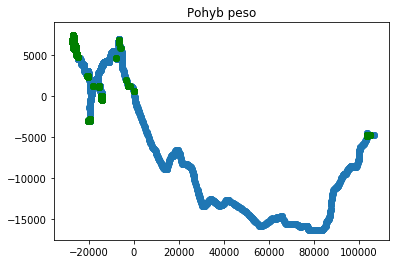

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5216 but corresponding boolean dimension is 5215


gpsdata/20081022.gpx


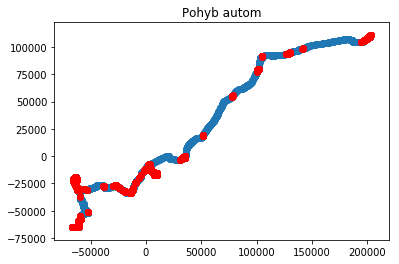

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5216 but corresponding boolean dimension is 5215


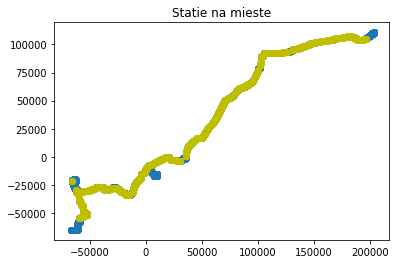

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5216 but corresponding boolean dimension is 5215


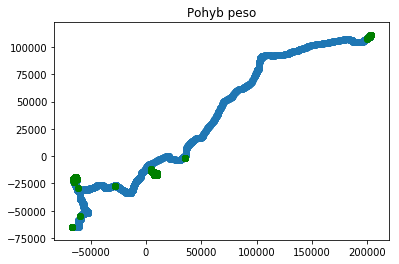

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2306 but corresponding boolean dimension is 2305


gpsdata/20081023.gpx


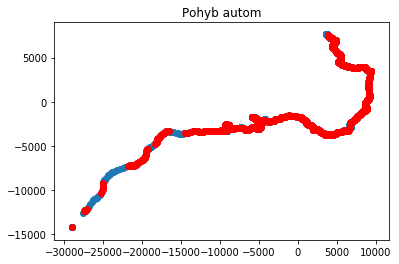

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2306 but corresponding boolean dimension is 2305


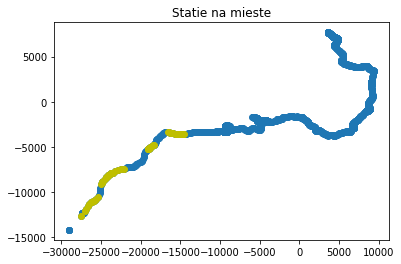

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2306 but corresponding boolean dimension is 2305


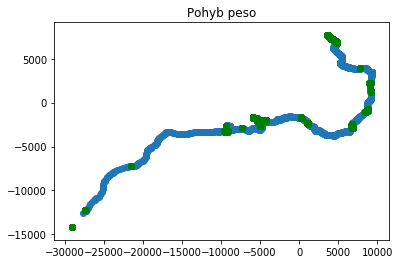

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3569 but corresponding boolean dimension is 3568


gpsdata/20081024.gpx


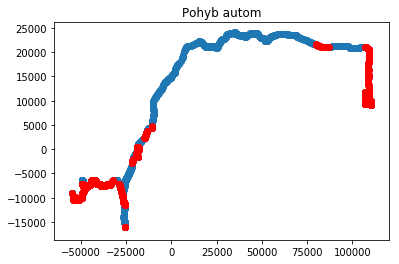

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3569 but corresponding boolean dimension is 3568


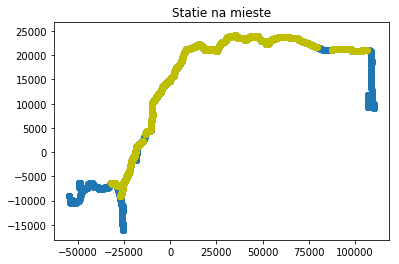

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3569 but corresponding boolean dimension is 3568


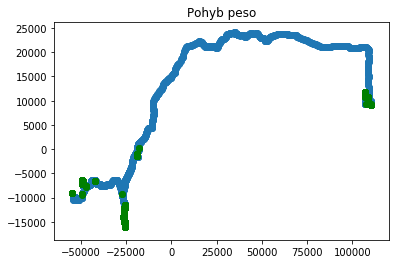

In [435]:
for i, points in enumerate(data):
    print(names[i])
    difs = to_difference(points)
    velocity = to_velocities(difs).reshape(-1,1)
    predictions = model.predict(velocity)
    
    plt.scatter(points[:-1,0], points[:-1,1])  # plot walk
    indices = predictions==0
    plt.scatter(points[indices,0], points[indices,1], c='r')  # plot car
    plt.title("Pohyb autom")
    plt.show()
    
    plt.scatter(points[:-1,0], points[:-1,1])  # plot walk
    indices = predictions==1
    plt.scatter(points[indices,0], points[indices,1], c='y')  # plot standing
    plt.title("Statie na mieste")
    plt.show()

    plt.scatter(points[:-1,0], points[:-1,1])  # plot walk
    indices = predictions==2
    plt.scatter(points[indices,0], points[indices,1], c='g')  # pohyb peso
    plt.title("Pohyb peso")
    plt.show()


Vidíme, že v dátach je veľmi málo úsekov, kedy sa naozaj išlo. Súsime Trochu pozmeniť počiatočné prechody.

In [449]:
remodel = hmm.GaussianHMM(n_components=3, covariance_type="diag")
remodel.startprob_ = np.array([0.3, 0.1, 0.3])
remodel.transmat_ = np.array([[0.99, 0.001, 0.009],     # auto
                              [0.001, 0.9, 0.099],      # stoji
                              [0.09, 0.001, 0.99]])     # peso
remodel.means_ = np.array([[30], [0.1], [1.8]])
remodel.covars_ = [[[2]],[[2]],[[10]]]
remodel.n_features = 1

remodel.fit(train_data, lengths)  


/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWar

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

gpsdata/20081009.gpx


/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3665 but corresponding boolean dimension is 3664


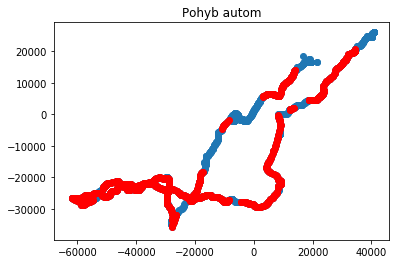

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3665 but corresponding boolean dimension is 3664


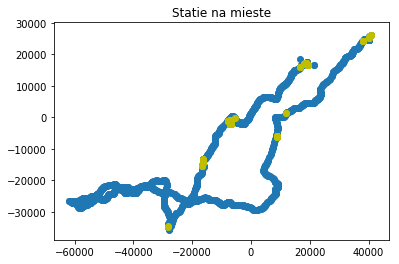

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3665 but corresponding boolean dimension is 3664


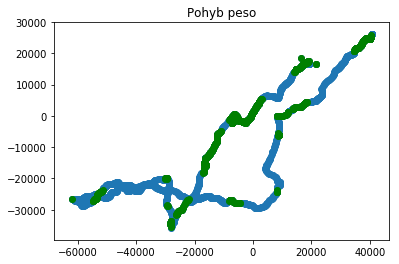

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1924 but corresponding boolean dimension is 1923


gpsdata/20081010.gpx


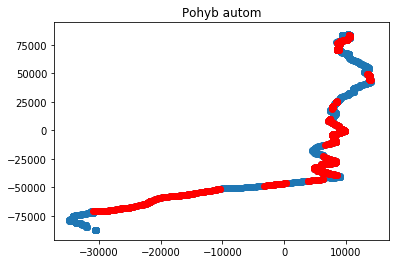

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1924 but corresponding boolean dimension is 1923


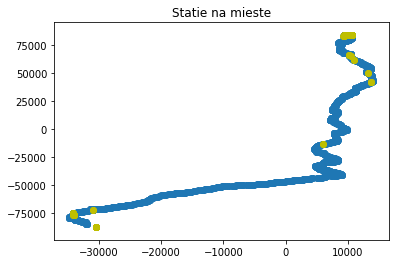

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1924 but corresponding boolean dimension is 1923


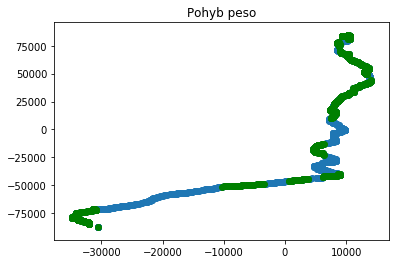

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4937 but corresponding boolean dimension is 4936


gpsdata/20081011.gpx


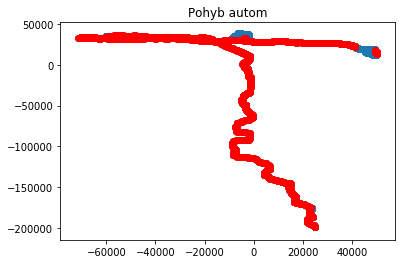

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4937 but corresponding boolean dimension is 4936


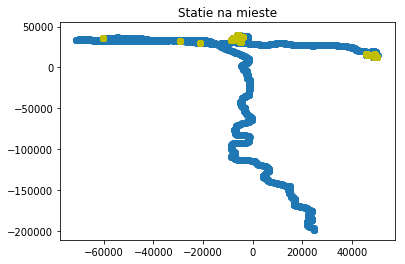

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4937 but corresponding boolean dimension is 4936


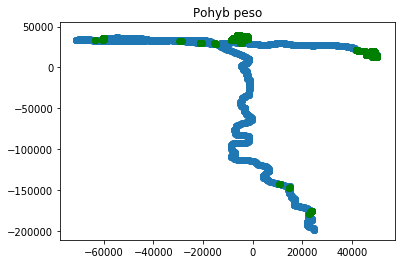

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 561 but corresponding boolean dimension is 560


gpsdata/20081012.gpx


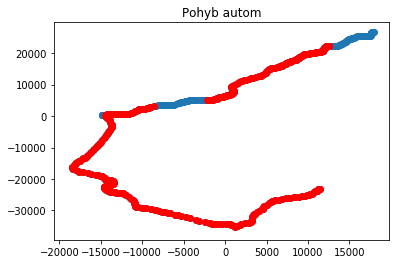

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 561 but corresponding boolean dimension is 560


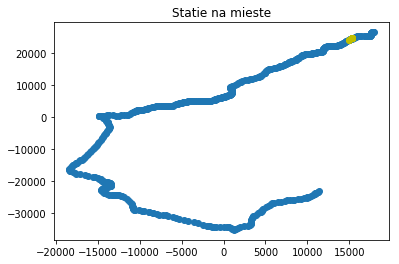

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 561 but corresponding boolean dimension is 560


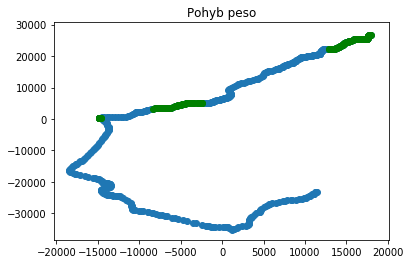

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


gpsdata/20081017.gpx


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1263 but corresponding boolean dimension is 1262


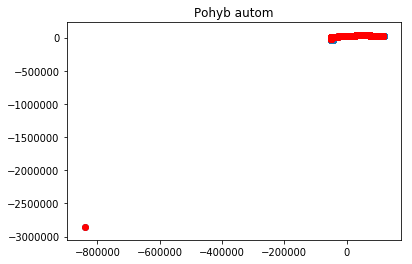

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1263 but corresponding boolean dimension is 1262


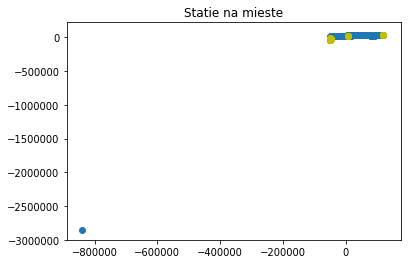

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1263 but corresponding boolean dimension is 1262


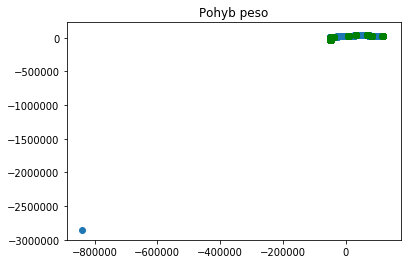

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2119 but corresponding boolean dimension is 2118


gpsdata/20081018.gpx


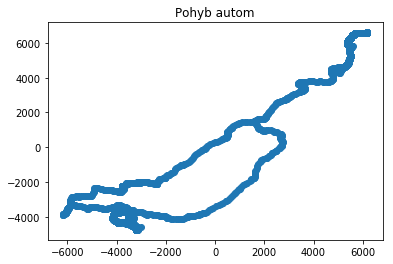

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2119 but corresponding boolean dimension is 2118


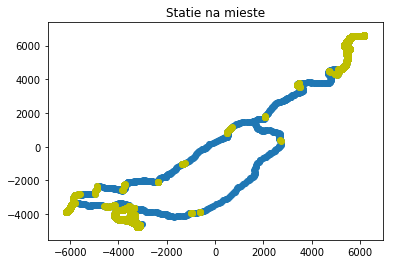

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2119 but corresponding boolean dimension is 2118


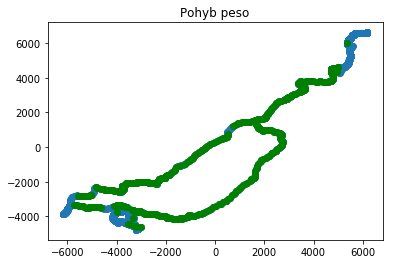

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4874 but corresponding boolean dimension is 4873


gpsdata/20081019.gpx


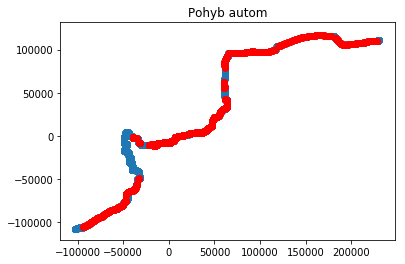

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4874 but corresponding boolean dimension is 4873


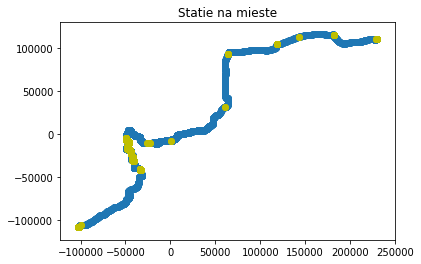

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4874 but corresponding boolean dimension is 4873


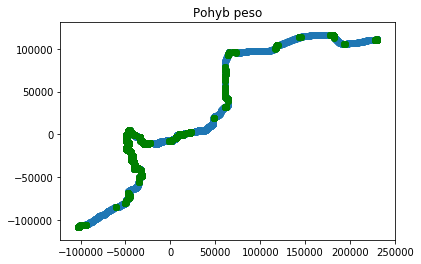

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5169 but corresponding boolean dimension is 5168


gpsdata/20081020.gpx


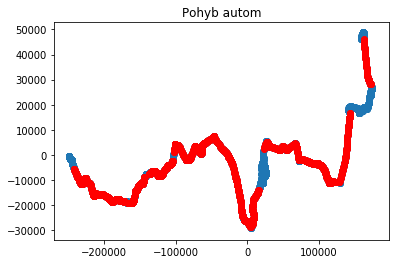

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5169 but corresponding boolean dimension is 5168


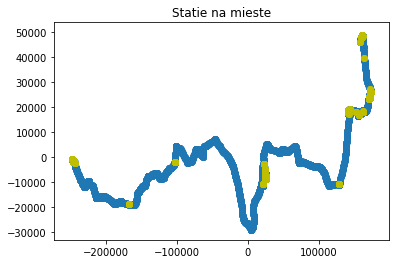

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5169 but corresponding boolean dimension is 5168


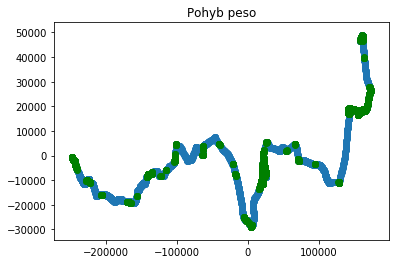

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4435 but corresponding boolean dimension is 4434


gpsdata/20081021.gpx


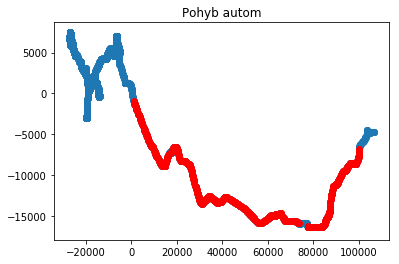

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4435 but corresponding boolean dimension is 4434


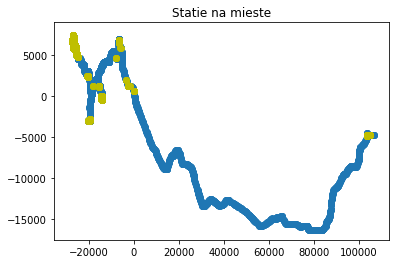

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4435 but corresponding boolean dimension is 4434


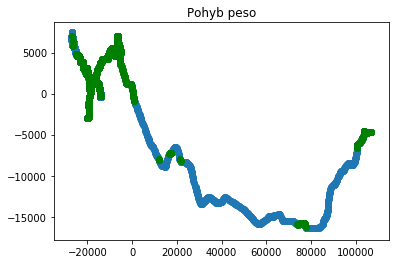

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5216 but corresponding boolean dimension is 5215


gpsdata/20081022.gpx


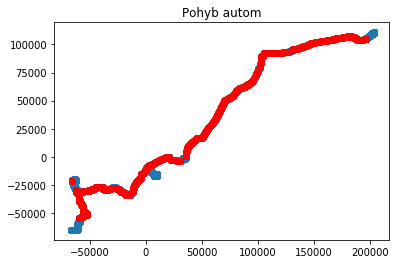

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5216 but corresponding boolean dimension is 5215


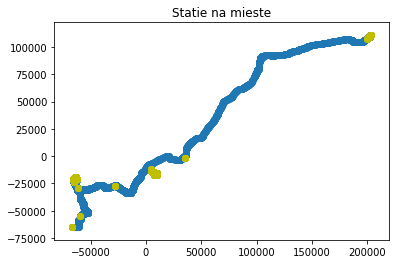

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5216 but corresponding boolean dimension is 5215


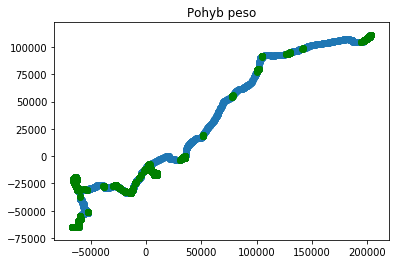

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2306 but corresponding boolean dimension is 2305


gpsdata/20081023.gpx


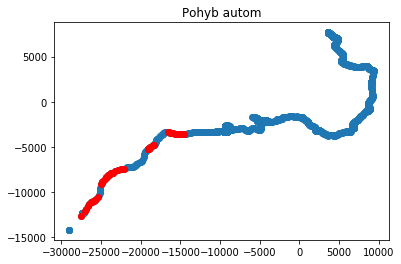

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2306 but corresponding boolean dimension is 2305


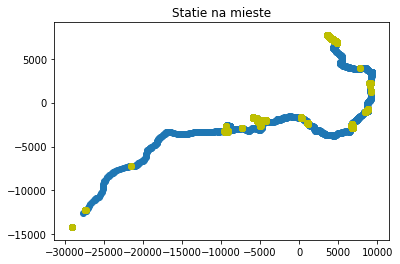

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2306 but corresponding boolean dimension is 2305


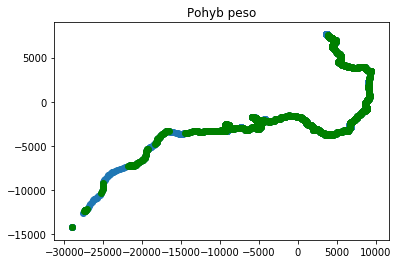

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3569 but corresponding boolean dimension is 3568


gpsdata/20081024.gpx


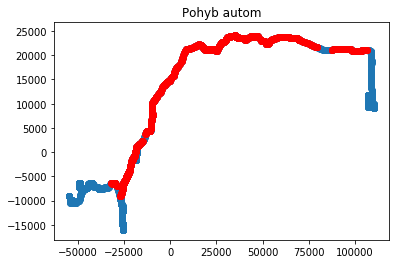

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3569 but corresponding boolean dimension is 3568


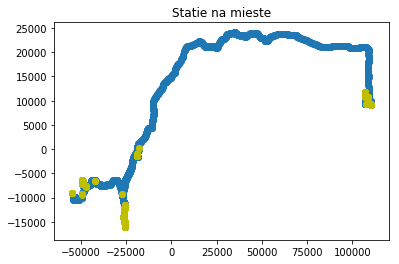

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 3569 but corresponding boolean dimension is 3568


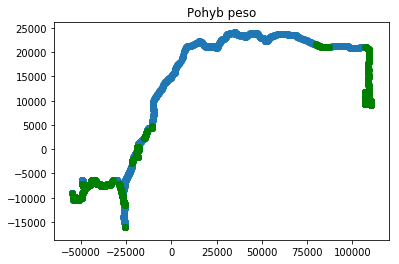

In [450]:
for i, points in enumerate(data):
    print(names[i])
    difs = to_difference(points)
    velocity = to_velocities(difs).reshape(-1,1)
    predictions = remodel.predict(velocity)
    
    plt.scatter(points[:-1,0], points[:-1,1])  # plot walk
    indices = predictions==0
    plt.scatter(points[indices,0], points[indices,1], c='r')  # plot car
    plt.title("Pohyb autom")
    plt.show()
    
    plt.scatter(points[:-1,0], points[:-1,1])  # plot walk
    indices = predictions==1
    plt.scatter(points[indices,0], points[indices,1], c='y')  # plot standing
    plt.title("Statie na mieste")
    plt.show()

    plt.scatter(points[:-1,0], points[:-1,1])  # plot walk
    indices = predictions==2
    plt.scatter(points[indices,0], points[indices,1], c='g')  # pohyb peso
    plt.title("Pohyb peso")
    plt.show()


Tato zmena parametrov predpokladala, že medzi pohybom autom a kráčaním nemáme prestávku. Vidíme, že nám vznikli pekné dlhé úseky cestovania autom a kráčania, s malými prestávkami.